In [ ]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [ ]:
import json
import urllib.request
import os

# Download data files if not exist
data_urls = {
    'imgcap.npz': 'https://github.com/nongaussian/class-2026-lginnotek-llm/raw/refs/heads/main/imgcap/imgcap.npz',
    'imgcap_output_vocab.json': 'https://raw.githubusercontent.com/nongaussian/class-2026-lginnotek-llm/refs/heads/main/imgcap/imgcap_output_vocab.json'
}

for filename, url in data_urls.items():
    if not os.path.exists(filename):
        print(f'Downloading {filename}...')
        urllib.request.urlretrieve(url, filename)
        print(f'{filename} downloaded.')
    else:
        print(f'{filename} already exists.')

npzfile = np.load('imgcap.npz')
input_imgs = npzfile['input_imgs']
output_seqs = npzfile['output_seqs']

with open("imgcap_output_vocab.json", "rb") as f:
    output_vocab = json.load(f)

y_vocab_size = len(output_vocab)
inverse_output_vocab = {index: token for token, index in output_vocab.items()}

# PyTorch uses (N, C, H, W) format, so we expand and transpose
input_imgs = np.expand_dims(input_imgs, axis=1)  # (N, 1, H, W)

imgcap.npz downloaded.
imgcap_output_vocab.json downloaded.


In [ ]:
input_imgs.shape

(4434, 1, 28, 28)

In [ ]:
output_seqs.shape

(4434, 202)

### Check image and caption

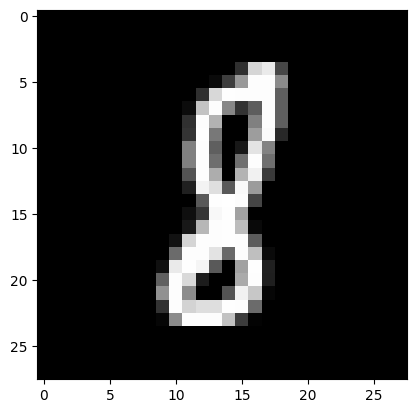

In [ ]:
plt.imshow(input_imgs[3931, 0, :, :], cmap='gray')

In [ ]:
output_seqs[3931]

array([    1,    79,   408,  2139,    54,    15,  3332,   407,  3001,
         785,   542,     7, 10367,   831,     6,  5250,  1420,    10,
          11,     7,   473,     6,    16,  5425, 10368,    10,   172,
         831,     6,  2670,  1420,    10,    78,   133,    54, 10369,
         232,  1334,  3325,    10,    26,   286,    25,   101,  6906,
           6, 10370,     2,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [ ]:
def text_decoding(line, invvocab):
    return [invvocab[x] for x in line]

In [ ]:
print(text_decoding(output_seqs[3931], inverse_output_vocab))

['<bos>', 'this', 'cycle', 'seem', 'to', 'be', 'neither', 'more', 'nor', 'less', 'than', 'the', 'calippic', 'period', 'of', 'seventy-six', 'years', ',', 'with', 'the', 'addition', 'of', 'a', 'greek', 'octaeteris', ',', 'or', 'period', 'of', 'eight', 'years', ',', 'in', 'order', 'to', 'disguise', 'its', 'true', 'source', ',', 'and', 'give', 'it', 'an', 'appearance', 'of', 'originality', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',

### Building models

In [ ]:
BATCH_SIZE = 16
embedding_dim = 1024
latent_dim = 100
output_vocab_size = len(output_vocab)

In [ ]:
class ImageCaptionDataset(Dataset):
    def __init__(self, images, captions):
        self.images = torch.FloatTensor(images)
        self.captions = torch.LongTensor(captions)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.captions[idx]

dataset = ImageCaptionDataset(input_imgs, output_seqs)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

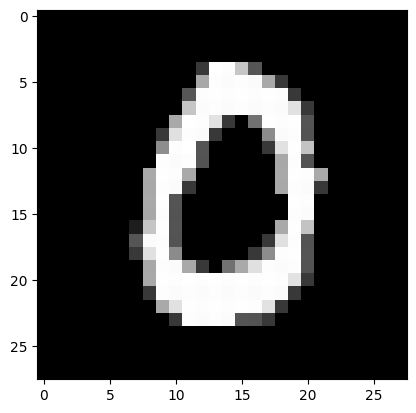

In [ ]:
# Get example batch
for example_input_batch, example_target_batch in dataloader:
    plt.imshow(example_input_batch[5, 0].numpy(), cmap='gray')
    break

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim=100):
        super(Encoder, self).__init__()
        # LeNet-like architecture
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # padding='same'
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)  # padding='valid'
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, latent_dim)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
encoder = Encoder(latent_dim).to(device)

In [ ]:
example_input_batch.shape

torch.Size([16, 1, 28, 28])

In [ ]:
last_state = encoder(example_input_batch.to(device))
print(last_state.shape)

torch.Size([16, 100])


In [ ]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, latent_dim):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, latent_dim, batch_first=True)
        self.fc = nn.Linear(latent_dim, vocab_size)

    def forward(self, target_seq, initial_state):
        # target_seq: (batch_size, seq_len)
        # initial_state: (batch_size, latent_dim)

        embedded = self.embedding(target_seq)  # (batch_size, seq_len, embedding_dim)

        output, hidden = self.gru(embedded, hidden)
        # output: (batch_size, seq_len, latent_dim)
        # hidden: (1, batch_size, latent_dim)

        logits = self.fc(output)  # (batch_size, seq_len, vocab_size)

        return logits, hidden.squeeze(0)  # return hidden as (batch_size, latent_dim)

In [ ]:
decoder = Decoder(y_vocab_size, embedding_dim, latent_dim).to(device)
logits, s1 = decoder(example_target_batch.to(device), last_state)

In [ ]:
print(logits.shape, s1.shape)

torch.Size([16, 202, 12087]) torch.Size([16, 100])


### Loss function

In [ ]:
def batch_loss(y_true, y_pred):
    # y_true: (batch_size, seq_len)
    # y_pred: (batch_size, seq_len, vocab_size)

    # Compute cross entropy loss
    loss = F.cross_entropy(y_pred.reshape(-1, y_pred.size(-1)),
                           y_true.reshape(-1),
                           reduction='none')
    loss = loss.view(y_true.shape)

    # Apply mask for padding tokens
    mask = (y_true != 0).float()
    loss = loss * mask

    return loss.sum() / mask.sum()

In [ ]:
batch_loss(example_target_batch[:, 1:].to(device), logits[:, :-1, :])

tensor(9.4713, grad_fn=<DivBackward0>)

### Training

In [ ]:
# Re-initialize models
encoder = Encoder(latent_dim).to(device)
decoder = Decoder(y_vocab_size, embedding_dim, latent_dim).to(device)

# Combine parameters for optimizer
params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=1e-4)

In [ ]:
def predict(x_batch, y_batch, training=True):
    last_state = encoder(x_batch)
    logits, _ = decoder(y_batch, last_state)
    return logits

In [ ]:
def train_step(x_batch, y_batch):
    # 1. compact batch tensors
    max_len = (y_batch != 0).sum(dim=1).max().item()
    y_batch = y_batch[:, :max_len]

    optimizer.zero_grad()

    # 2. encoder & decoder
    logits = predict(x_batch, y_batch)

    # 3. loss
    loss = batch_loss(y_batch[:, 1:], logits[:, :-1, :])

    loss.backward()
    optimizer.step()

    return loss.item()

In [ ]:
for epoch in range(50):
    start = time.time()

    encoder.train()
    decoder.train()

    loss_sum = 0
    for x_batch, y_batch in dataloader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        loss = train_step(x_batch, y_batch)
        loss_sum += loss

    print('Time for epoch {} is {:.2f} sec: training loss = {:.4f}'.format(
        epoch + 1, time.time() - start, loss))

Time for epoch 1 is 28.20 sec: training loss = 4.0280
Time for epoch 2 is 29.14 sec: training loss = 3.2305
Time for epoch 3 is 26.75 sec: training loss = 3.0475
Time for epoch 4 is 27.02 sec: training loss = 3.4889
Time for epoch 5 is 27.77 sec: training loss = 3.6889
Time for epoch 6 is 27.11 sec: training loss = 3.4689
Time for epoch 7 is 26.74 sec: training loss = 3.7091
Time for epoch 8 is 26.21 sec: training loss = 3.9377
Time for epoch 9 is 25.95 sec: training loss = 2.8849
Time for epoch 10 is 26.88 sec: training loss = 4.1272
Time for epoch 11 is 28.06 sec: training loss = 2.5592
Time for epoch 12 is 29.64 sec: training loss = 3.2567
Time for epoch 13 is 27.56 sec: training loss = 3.9935
Time for epoch 14 is 27.47 sec: training loss = 3.2179
Time for epoch 15 is 27.47 sec: training loss = 3.3290
Time for epoch 16 is 28.11 sec: training loss = 3.9959
Time for epoch 17 is 27.31 sec: training loss = 2.7071
Time for epoch 18 is 26.65 sec: training loss = 2.0904
Time for epoch 19 i

### Test translation

In [ ]:
def beam_translate(x_test, max_steps=100, k=16):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        # compute encoder and get hidden status
        s1 = encoder(x_test)

        # init candidates
        bos_token = output_vocab['<bos>']
        last_token = torch.tensor([[bos_token]], device=device)
        candidates = [(0., last_token, s1, [bos_token], False)]

        for _ in range(max_steps):
            new_candidates = []

            for score, token, hidden, output_seq, eos in candidates:
                # if the candidate already ends,
                if eos:
                    new_candidates.append((score, token, hidden, output_seq, eos))
                    continue

                # compute the prob. of following tokens
                logits, hidden = decoder(token, hidden)
                # shape of logits (1, 1, vocab_size)
                probs = F.log_softmax(logits, dim=2)

                # use the token with the top-k logits as the input
                # of the decoder at the next time step
                values, indices = torch.topk(probs.squeeze(), k=k)

                for prob, idx in zip(values, indices):
                    idx_int = idx.item()
                    # if prediction is eos, output sequence is complete
                    eos = (idx_int == output_vocab['<eos>'])

                    last_token = torch.tensor([[idx_int]], device=device)
                    new_candidates.append(
                        (score + prob.item(), last_token, hidden,
                         output_seq + [idx_int], eos))

            candidates = sorted(new_candidates, key=lambda t: -t[0])[:k]

        return [(candidates[i][0], ' '.join([inverse_output_vocab[x] for x in candidates[i][3]]))
                for i in range(k)]

In [ ]:
# Get a fresh batch for testing
for example_input_batch, example_target_batch in dataloader:
    example_input_batch = example_input_batch.to(device)
    break

res = beam_translate(example_input_batch[0:1])
res[0]

(-6.695853850804269, '<bos> there be only one <eos>')

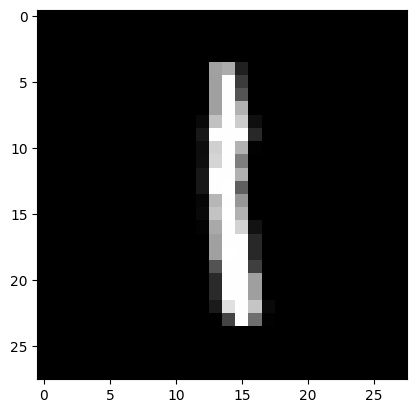

In [ ]:
plt.imshow(example_input_batch[0, 0].cpu().numpy(), cmap='gray')